# This is a test of SINDy

This test will use the code provided by Christian Mannov

### Todo
- Vi skal se om det kan blive en anden ordens diff ligning (x'')
- evt. brug v_x til at være andet komponent
- Find ud af om vi kan bruge elipser i SINDy (måske kan vi selv inputte 1/r^3)
- Vi skal have flere legmer ind (Solen, jorden, jupiter)
- (Done) - lav plot function

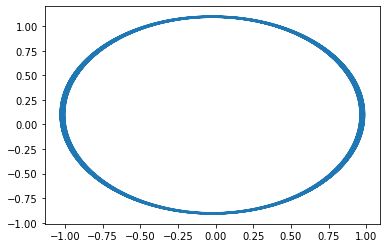

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

x = np.load('earth_pos.npy')
x = np.delete(x, 2, 1) # deletes z-coordinates

plt.plot(x[:,0], x[:,1])

In [2]:
def plot(x, y, x_model, y_model):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5.5))
    ax[0].plot(x, y, label='Data')
    ax[0].plot(x_model, y_model, '-', label='SINDy')
    ax[0].set(xlabel='x', ylabel='y')
    ax[1].set(xlabel='x', ylabel='y')
    #ax.legend()

## Model without optimization

x0' = 0.000
x1' = 0.000


C:\Users\tobiaha\Anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:163: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


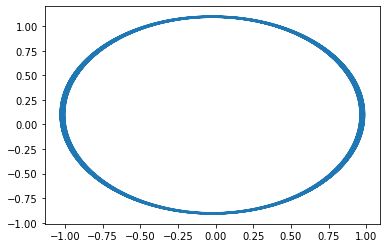

In [3]:
model = ps.SINDy()

t = np.arange(0, x.shape[0], 1) # timesteps are in days

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

plt.plot(x[:, 0], x[:, 1])
plt.plot(x_model[:, 0], x_model[:, 1])

## Model with adjusted threshold

x' = 0.016 y
y' = -0.017 x


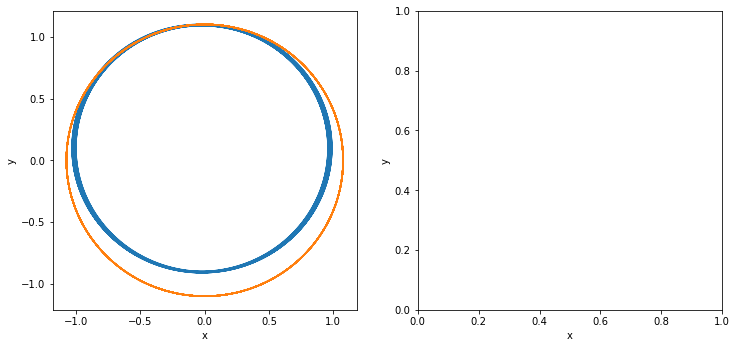

In [4]:
optimizer = ps.STLSQ(threshold=0.01)#, fit_intercept=True, normalize=True)

model = ps.SINDy(
        optimizer=optimizer,
        feature_names = ['x', 'y'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax.plot(x[:, 0], x[:, 1], label='Data')
#ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
#ax.set(xlabel='x', ylabel='y')
#ax.legend()
plot(x[:, 0], x[:, 1], x_model[:, 0], x_model[:, 1])

## Model with adjusted threshold and fit intercept

x' = 0.018 y + -0.002 y^2 + -0.002
y' = -0.017 x + 0.002 x y + -0.001


0.9998550433371398

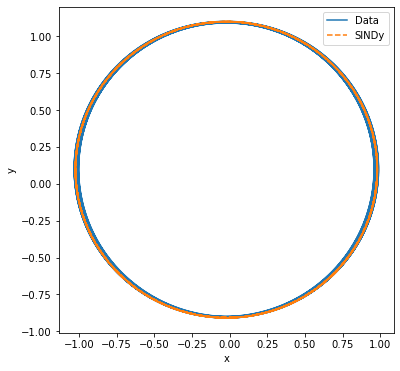

In [5]:
optimizer = ps.STLSQ(threshold=0.0001, fit_intercept=True)

model = ps.SINDy(
        optimizer=optimizer,
        feature_names = ['x', 'y'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
model.score(x, t=t)

The code above was began with a threshold of 0.1, but as we investigated further, this 0.0001 threshold seems to model quite good. It still doesn't model with 0% error to the data, but right now 0.0001 threshold is really good. 

### 2nd order

Below is an attempt on using a different differentiation method. The code didn't seem to spit out 2nd order diff eqs although we tried to force it. 

This source (https://www.pnas.org/content/116/45/22445) claims to have used sindy to model a 2nd order diff eq, but we are not sure how the did it exactly... yet. 

#### Update (20/3-21)
We tried using `diff_method = ps.FiniteDifference(order=2)` but realised that this did not force SINDy to produce a 2nd order diff eq. 

The next thing were working on is differentiating outside SINDy and then telling SINDy what our x_dot is. This introduces the problem that `x` and `t` has the same length, but `xd` is one unit shorter because of the diff. Further investigation will be made. 
This guy might be able to help with building the differentiation from the bottom: https://www.youtube.com/watch?v=9G16HYUgENo

#### Update (23/3-21)

By recommendation (Shrøder)
- Try using central difference. `numpy.gradient` might also be a solution. 
    - Try this for a sine curve first and see if it makes sense

Using the burner script (SINDy burner), use of `np.gradient` was acheived. The model is running and doing that with minimal loss of precision. [This page](https://stackoverflow.com/questions/24633618/what-does-numpy-gradient-do/24633888) was especially helpful sorrounding `np.gradient`.

x' = 0.018 y + -0.002 y^2 + -0.002
y' = -0.017 x + 0.002 x y + -0.001


0.999855043336404

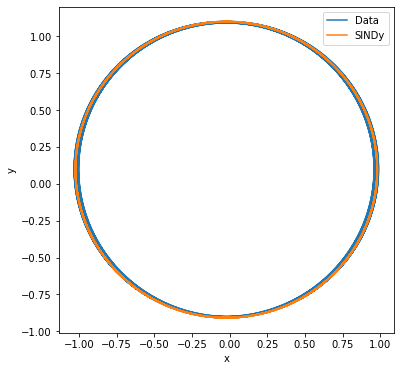

In [6]:
optimizer = ps.STLSQ(threshold=0.0001, fit_intercept=True)
# diff_method = ps.FiniteDifference(order=2)

# -------------------
def dif(x, y):
    '''Numerical differential using both forward and backwards difference quotient.'''
    dyforward = [0.0] * len(x)
    for i in range(len(y)-1):
        dyforward[i] = (y[i+1]-y[i])/(x[i+1]-x[i])
    # Compensating for the last datapoint:
    dyforward[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
    return dyforward
# -------------------

model = ps.SINDy( 
        optimizer=optimizer,
        feature_names = ['x', 'y'])

xd = np.gradient(x[:, 0], t)
yd = np.gradient(x[:, 1], t)
dot = np.array([xd, yd]).T # .T is to transpose the array


model.fit(x, t=t, x_dot=dot)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '-', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
model.score(x, t=t)

## The 2nd order model

The code below will act as a last step before writing the final notebook. The code will take the things found in the code above and make it ready for implementation. 

x' = -0.000
y' = 0.000


-0.0002978330524111561

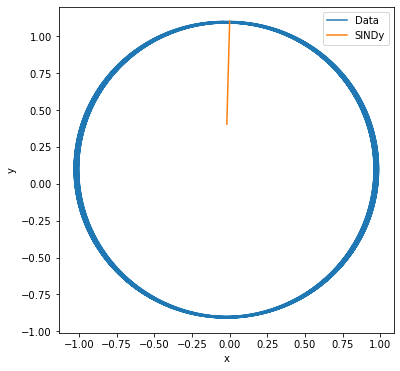

In [7]:
optimizer = ps.STLSQ(threshold=0.0001, fit_intercept=True)

model = ps.SINDy( 
        optimizer=optimizer,
        feature_names = ['x', 'y'])

xd = np.gradient(x[:, 0], t)
yd = np.gradient(x[:, 1], t)
dot = np.array([xd, yd]).T # .T is to transpose the array

xdd = np.gradient(xd, t)
ydd = np.gradient(yd, t)
ddot = np.array([xdd, ydd]).T

model.fit(x, t=t, x_dot=ddot)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '-', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
model.score(x, t=t)

## Introducing the custom library

(7/4-21) The first itteration of the custom library is in the file `customlibrary`. It is based on the documentation of the SINDy libraries, which is found [here](https://pysindy.readthedocs.io/en/latest/api/pysindy.html#submodules). 
Obviously this did not work the first time around, but it will eventually. \

#### Update (10/4-21) 
I'm pretty sure we do not need the `PolynomialLibrary`, it seems that `ConcatLibrary()` uses the base library regardless of what one puts into the `ConcatLibrary`. Removing `PolynomialLibrary` results in a new error tho. It says that we're dividing by zero, so that is the next thing to investigate. 

What i dumb dumb I am... `^` does not raise powers in python "facepalm". Still gives the divide by zero error tho. 

#### Update (13/4-21)
After consulting Shrøder, we found the error. We weren't meant to have `1/x**3` but rather `x/(x**2+y**2)**(3/2)` (i.e. `x` divided by the length of `r`). We also needed to change the variables in `lambda` to `x,y` since the custom functions now where dependend on both. 

This correction actually gave an result which weren't half bad. 

#### Update (22/4-21)
One thing that was also pointed out by shrøder is that using the `model.simulate` doesn't really do us any good since it assumes the function to be of first order, which ours isn't. 

In [8]:
from pysindy.feature_library import PolynomialLibrary, CustomLibrary
from pysindy.feature_library import ConcatLibrary


functions = [lambda x,y : x/(x**2+y**2)**(3/2), lambda x,y : y/(x**2+y**2)**(3/2)] # The specific functions we're looking for
#lib_poly = PolynomialLibrary
lib_custom = CustomLibrary(library_functions=functions) # defines the custom library we want to use
lib_concat = ConcatLibrary([lib_custom])

optimizer = ps.STLSQ(threshold=0.0001, fit_intercept=True)

model = ps.SINDy( 
        feature_library = lib_concat, 
        optimizer=optimizer,
        feature_names = ['x', 'y'])

xd = np.gradient(x[:, 0], t)
yd = np.gradient(x[:, 1], t)
dot = np.array([xd, yd]).T # .T is to transpose the array

print('Model where we define X_dot')
model.fit(x, t=t, x_dot=dot)
model.print()
print('That models score')
model.score(x, t=t)



Model where we define X_dot
x' = 0.017 f1(x,y)
y' = -0.017 f0(x,y)
That models score


0.9901539400167916

### dot vs v
In the underlying section we'll be testing if feeding the velocity directly to SINDy is a better option than giving it the positions.

Writing this, I realise that the `x_dot` we use in the preceding section actually gives us the velocities. Hence we should test `x_dot` fed right to SINDy and `v_dot` and tell SINDy that `X_dot = v_dot`

#### Update (22/4-21)
Threshold adjusted from 1e-4 to 1e-5 to 1e-6 to 1e-15. For `model.fit(dot, t=t)` this just equated 0 for both equations. Good news is that `model.fit(v, t=t)` does produce equations, analysis will tell if they're any good.

In [9]:
from pysindy.feature_library import PolynomialLibrary, CustomLibrary
from pysindy.feature_library import ConcatLibrary


functions = [lambda x,y : x/(x**2+y**2)**(3/2), lambda x,y : y/(x**2+y**2)**(3/2)] # The specific functions we're looking for
#lib_poly = PolynomialLibrary
lib_custom = CustomLibrary(library_functions=functions) # defines the custom library we want to use
lib_concat = ConcatLibrary([lib_custom])

optimizer = ps.STLSQ(threshold=1e-15, fit_intercept=True)

model = ps.SINDy( 
        feature_library = lib_concat, 
        optimizer=optimizer,
        feature_names = ['x', 'y'])

xd = np.gradient(x[:, 0], t)
yd = np.gradient(x[:, 1], t)
dot = np.array([xd, yd]).T # .T is to transpose the array

print('Model where we define X_dot (which gives vel)')
model.fit(x, t=t, x_dot=dot)
model.print()
#print('That models score')
#model.score(x, t=t)

print('Model where we feed dot into SINDy (which gives acc)')
model.fit(dot, t=t)
model.print()

v = np.load('earth_vel.npy')
v = np.delete(v, 2, 1) # deletes z-coordinates

print('Model where we feed v to SINDy (which gives acc)')
model.fit(v, t=t)
model.print()


xdd = np.gradient(xd, t)
ydd = np.gradient(yd, t)
ddot = np.array([xdd, ydd]).T

print('Model where we use the 2nd order manual diff')
model.fit(x, t=t, x_dot=ddot)
model.print()

Model where we define X_dot (which gives vel)
x' = 0.017 f1(x,y)
y' = -0.017 f0(x,y)
Model where we feed dot into SINDy (which gives acc)
x' = -0.000
y' = 0.000
Model where we feed v to SINDy (which gives acc)
x' = -0.001 f0(x,y) + 4.122 f1(x,y) + -0.001
y' = -4.112 f0(x,y) + 0.001 f1(x,y) + 0.015
Model where we use the 2nd order manual diff
x' = 0.000
y' = 0.000


## Implemantation of `jit`

#### Update (25/4-21)
To implement `numba` and `jit`/`njit` we need to make the script into a function since that is what `jit` works upon.

Now that the function is created, we need to resolve the issue where `numba` says that `lib_concat` is an unkown. 

In [10]:


def sindy(v, t):
    optimizer = ps.STLSQ(threshold=1e-15, fit_intercept=True)

    model = ps.SINDy( 
            feature_library = lib_concat, 
            optimizer=optimizer,
            feature_names = ['x', 'y'])
    
    xd = np.gradient(x[:, 0], t)
    yd = np.gradient(x[:, 1], t)
    dot = np.array([xd, yd]).T # .T is to transpose the array
    
    print('Model where we feed v to SINDy (which gives acc)')
    model.fit(v, t=t)
    model.print()
    


print('Original func time')
%time _ = sindy(v, t)

from numba import njit


jit_model = njit()(sindy)

print('jitted func time')
%time _ = jit_model(v, t)

Original func time
Model where we feed v to SINDy (which gives acc)
x' = -0.001 f0(x,y) + 4.122 f1(x,y) + -0.001
y' = -4.112 f0(x,y) + 0.001 f1(x,y) + 0.015
Wall time: 13 ms
jitted func time


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'lib_concat':[0m [1m[1mcannot determine Numba type of <class 'pysindy.feature_library.base.ConcatLibrary'>[0m
[1m
File "<ipython-input-10-3290f210b7f7>", line 5:[0m
[1mdef sindy(v, t):
    <source elided>
    model = ps.SINDy( 
[1m            feature_library = lib_concat, 
[0m            [1m^[0m[0m
[0m

# Using own data

In [22]:
from pysindy.feature_library import PolynomialLibrary, CustomLibrary
from pysindy.feature_library import ConcatLibrary
xt = np.load('t_earth_pos.npy')

functions = [lambda x,y : x/(x**2+y**2)**(3/2), lambda x,y : y/(x**2+y**2)**(3/2)] # The specific functions we're looking for
#lib_poly = PolynomialLibrary
lib_custom = CustomLibrary(library_functions=functions) # defines the custom library we want to use
lib_concat = ConcatLibrary([lib_custom])

optimizer = ps.STLSQ(threshold=1e-15, fit_intercept=True)

model = ps.SINDy( 
        feature_library = lib_concat, 
        optimizer=optimizer,
        feature_names = ['x', 'y'])

tt = np.arange(0, xt.shape[0], 1)

xtd = np.gradient(xt[:, 0], tt)
ytd = np.gradient(xt[:, 1], tt)
tdot = np.array([xtd, ytd]).T # .T is to transpose the array

print('Model where we define X_dot (which gives vel)')
model.fit(xt, t=tt, x_dot=tdot)
model.print()

xtdd = np.gradient(xtd, tt)
ytdd = np.gradient(ytd, tt)
tddot = np.array([xtdd, ytdd]).T

print('Model where we use the 2nd order manual diff')
model.fit(xtd, t=tt, x_dot=tddot)
model.print()

Model where we define X_dot (which gives vel)
x' = 0.006 f1(x,y)
y' = -0.006 f0(x,y)
Model where we use the 2nd order manual diff


ValueError: Found array with 0 feature(s) (shape=(100000, 0)) while a minimum of 1 is required.

In [14]:
print(xt)

[[0.00638791 0.98315923]
 [0.01277555 0.9830777 ]
 [0.01916265 0.98295541]
 ...
 [0.98333287 0.19664846]
 [0.98466768 0.19053197]
 [0.98596403 0.18440806]]


---
---
## Model with adjusted threshold, fit intercept and nomalization

In [ ]:
optimizer = ps.STLSQ(threshold=0.01, fit_intercept=True, normalize=True)

model = ps.SINDy(
        optimizer=optimizer,
        feature_names = ['x', 'y'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '-', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()

In [ ]:
optimizer = ps.STLSQ(threshold=0.01, normalize=True)

model = ps.SINDy(
        optimizer=optimizer,
        feature_names = ['x', 'y'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()

This nomalization does not seem to do us any good. We will therefore put it back on the shelf for now. 

## Fourier

The next few tries will be using the fourier libary. This was to try and see if trigonometric functions were a better fit than the usual polynomials. 

In [ ]:
fourier_library = ps.FourierLibrary(n_frequencies=2)
optimizer = ps.STLSQ(threshold=0.01)

model = ps.SINDy(
        feature_library = fourier_library,
        optimizer=optimizer,
        feature_names = ['x', 'y', 'z'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()

In [ ]:
fourier_library = ps.FourierLibrary(n_frequencies=2)
optimizer = ps.STLSQ(threshold=0.01, fit_intercept=True)

model = ps.SINDy(
        feature_library = fourier_library,
        optimizer=optimizer,
        feature_names = ['x', 'y', 'z'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()

In [ ]:
fourier_library = ps.FourierLibrary(n_frequencies=2)
optimizer = ps.STLSQ(threshold=0.001, fit_intercept=True)

model = ps.SINDy(
        feature_library = fourier_library,
        optimizer=optimizer,
        feature_names = ['x', 'y', 'z'])

model.fit(x, t=t)
model.print()

x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()

In [ ]:
# Loading in positions -----------------------------
xS = np.load('Sun_pos.npy')
xS = np.delete(xS, 2, 1) # deletes z-coordinates
xE = np.load('Earth_pos.npy')
xE = np.delete(xE, 2, 1) # deletes z-coordinates
xJ = np.load('Jupiter_pos.npy')
xJ = np.delete(xJ, 2, 1) # deletes z-coordinates

# Loading in velocities ----------------------------
vS = np.load('Sun_vel.npy')
vS = np.delete(vS, 2, 1) # deletes z-velocities
vE = np.load('Earth_vel.npy')
vE = np.delete(vE, 2, 1) # deletes z-velocities
vJ = np.load('Jupiter_vel.npy')
vJ = np.delete(vJ, 2, 1) # deletes z-velocities

In [ ]:
def plot(xS, yS, xE, yE, xJ, yJ, vxS, vxE, vxJ, t, 
         xS_model, yS_model, xE_model, yE_model, xJ_model, yJ_model, vxS_model, vxE_model, vxJ_model):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    # Plots the planets
    ax[0, 0].plot(xS, yS, label='Data Sun', color='darkorange')
    ax[0, 0].plot(xE, yE, label='Data Earth', color='royalblue')
    ax[0, 0].plot(xJ, yJ, label='Data Jupiter', color='saddlebrown')
    
    ax[1, 0].plot(xS_model, yS_model, label='SINDy Sun', color='darkorange')
    ax[1, 0].plot(xE_model, yE_model, label='SINDy Earth', color='royalblue')
    ax[1, 0].plot(xJ_model, yJ_model, label='SINDy Jupiter', color='saddlebrown')
    
    # Plots the velocities in the x-direction
    ax[0, 1].plot(t, vxS, label='Data Sun', color='darkorange')
    ax[0, 1].plot(t, vxE, label='Data Earth', color='royalblue')
    ax[0, 1].plot(t, vxJ, label='Data Jupiter', color='saddlebrown')
    
    ax[1, 1].plot(t, vxS_model, label='SINDy Sun', color='darkorange')
    ax[1, 1].plot(t, vxE_model, label='SINDy Earth', color='royalblue')
    ax[1, 1].plot(t, vxJ_model, label='SINDy Jupiter', color='saddlebrown')
    
    ax[0, 0].set(xlabel='x', ylabel='y')
    ax[1, 0].set(xlabel='x', ylabel='y')
    ax[0, 1].set(xlabel='t', ylabel='v_x')
    ax[1, 1].set(xlabel='t', ylabel='v_x')
    ax[0, 0].set_title('Position')
    ax[1, 0].set_title('SINDy Position')
    ax[0, 1].set_title('Velocities')
    ax[1, 1].set_title('SINDy Velocities')
    ax[0, 0].legend()
    ax[1, 0].legend()
    ax[0, 1].legend()
    ax[1, 1].legend()

In [ ]:
plot(xS[:, 0], xS[:, 1], xE[:, 0], xE[:, 1], xJ[:, 0], xJ[:, 1], vS[:, 0], vE[:, 0], vJ[:, 0], t, 
    0, 0, 0, 0, 0, 0, 0, 0, 0)

In [ ]:
optimizer = ps.STLSQ(threshold=0.0001, fit_intercept=True)

model = ps.SINDy(
        optimizer=optimizer,
        )#feature_names = ['xS', 'yS']

model.fit([xS, xE, xJ, vS, vE, vJ], t=t)
model.print()

x_model = model.simulate(x[0, :], t)

In [ ]:
dot